# Resource Download

In [13]:
# Download wav2lip model.（https://drive.google.com/file/d/1xn_LciZpxnfcInBH36QCYaVruTpkK5-n/view?usp=sharing）
!gdown 1xn_LciZpxnfcInBH36QCYaVruTpkK5-n

# Download test audio. (https://drive.google.com/file/d/1GViBil7-UbtxW90TQQE-CkaG0McJCSHf/view?usp=sharing)
!gdown 1GViBil7-UbtxW90TQQE-CkaG0McJCSHf

# Download figure image. (https://drive.google.com/file/d/1QLd8V-mwtl8EHladJ5M0Ru5u-0HO8ru0/view?usp=sharing)
!gdown 1QLd8V-mwtl8EHladJ5M0Ru5u-0HO8ru0

Downloading...
From (original): https://drive.google.com/uc?id=1xn_LciZpxnfcInBH36QCYaVruTpkK5-n
From (redirected): https://drive.google.com/uc?id=1xn_LciZpxnfcInBH36QCYaVruTpkK5-n&confirm=t&uuid=c9535eda-de28-454c-b5dc-52c9603290ce
To: /content/wav2lip.pth
100% 436M/436M [00:02<00:00, 200MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GViBil7-UbtxW90TQQE-CkaG0McJCSHf
To: /content/hello.mp3
100% 33.8k/33.8k [00:00<00:00, 57.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QLd8V-mwtl8EHladJ5M0Ru5u-0HO8ru0
To: /content/figure.jpg
100% 17.3k/17.3k [00:00<00:00, 39.6MB/s]


# Wav2Lip Model

In [14]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv2d(nn.Module):
    """
    Convolutional layer with batch normalization and ReLU activation.
    """
    def __init__(self,
                 cin, # input channel
                 cout, # output channel
                 kernel_size, # kernel size
                 stride, # stride
                 padding, # padding
                 residual=False, # residual connection
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.Conv2d(cin, cout, kernel_size, stride, padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()
        self.residual = residual

    def forward(self, x):
        out = self.conv_block(x)
        if self.residual:
            out += x
        return self.act(out)

In [15]:
class Conv2dTranspose(nn.Module):
    """
    Convolutional transpose layer with batch normalization and ReLU activation.
    """
    def __init__(self, cin, cout, kernel_size, stride, padding, output_padding=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv_block = nn.Sequential(
                            nn.ConvTranspose2d(cin, cout, kernel_size, stride, padding, output_padding),
                            nn.BatchNorm2d(cout)
                            )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.conv_block(x)
        return self.act(out)

In [16]:
class Wav2Lip(nn.Module):
    def __init__(self):
        super(Wav2Lip, self).__init__()

        self.face_encoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(6, 16, kernel_size=7, stride=1, padding=3)), # 16, 96, 96

            nn.Sequential(Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 32, 48, 48
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(32, 64, kernel_size=3, stride=2, padding=1),    # 64, 24, 24
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(64, 128, kernel_size=3, stride=2, padding=1),   # 128, 12, 12
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(128, 256, kernel_size=3, stride=2, padding=1),       # 256, 6, 6
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True)),

            nn.Sequential(Conv2d(256, 512, kernel_size=3, stride=2, padding=1),     # 512, 3, 3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),

            nn.Sequential(Conv2d(512, 512, kernel_size=3, stride=1, padding=0),     # 512, 1, 1
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0)),])

        self.audio_encoder = nn.Sequential(
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(32, 32, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(32, 64, kernel_size=3, stride=(3, 1), padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(64, 128, kernel_size=3, stride=3, padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(128, 256, kernel_size=3, stride=(3, 2), padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),

            Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            Conv2d(512, 512, kernel_size=1, stride=1, padding=0),)

        self.face_decoder_blocks = nn.ModuleList([
            nn.Sequential(Conv2d(512, 512, kernel_size=1, stride=1, padding=0),),  # 512, 1, 1

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=1, padding=0), # 512, 3, 3
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),),

            nn.Sequential(Conv2dTranspose(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(512, 512, kernel_size=3, stride=1, padding=1, residual=True),), # 512, 6, 6

            nn.Sequential(Conv2dTranspose(768, 384, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(384, 384, kernel_size=3, stride=1, padding=1, residual=True),), # 384, 12, 12

            nn.Sequential(Conv2dTranspose(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(256, 256, kernel_size=3, stride=1, padding=1, residual=True),), # 256, 24, 24

            nn.Sequential(Conv2dTranspose(320, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1, residual=True),), # 128, 48, 48

            nn.Sequential(Conv2dTranspose(160, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),
            Conv2d(64, 64, kernel_size=3, stride=1, padding=1, residual=True),),]) # 64, 96, 96

        self.output_block = nn.Sequential(Conv2d(80, 32, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid())

    def forward(self, audio_sequences, face_sequences):
        audio_embedding = self.audio_encoder(audio_sequences) # B, 512, 1, 1

        feats = []
        x = face_sequences
        for f in self.face_encoder_blocks:
            x = f(x)
            feats.append(x)

        x = audio_embedding  # B, 512, X, X
        for f in self.face_decoder_blocks:
            x = f(x)  # B, 512, X, X
            try:
                x = torch.cat((x, feats[-1]), dim=1)  # B, 1024, X, X
            except Exception as e:
                print(x.size())
                print(feats[-1].size())
                raise e

            feats.pop()

        return self.output_block(x)

# Image Process

In [17]:
# For simplicity, we don't use face detection module.
face_box = [47, 179, 197, 284]
image_path = "figure.jpg"

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread(image_path)

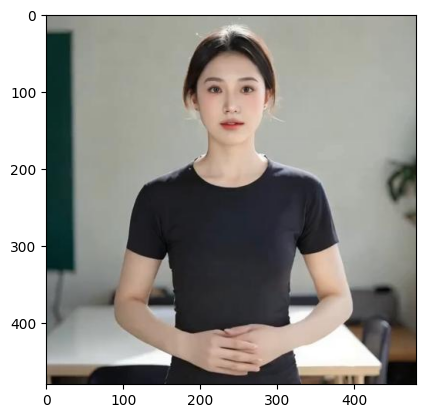

In [19]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# Extract face from the image.
y1, y2, x1, x2 = face_box
face = image[y1: y2, x1:x2]

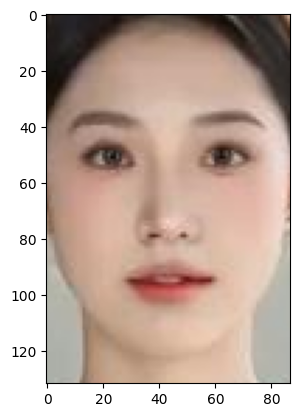

In [21]:
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.show()

In [22]:
# Resize face resolution to 96x96
face = cv2.resize(face, (96, 96))

In [23]:
# Mask the lower part of the face.
masked_face = face.copy()
masked_face[48:] = 0

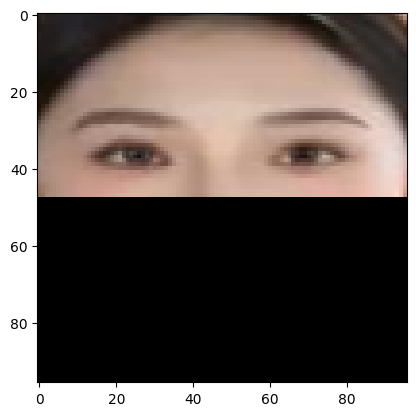

In [24]:
plt.imshow(cv2.cvtColor(masked_face, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
# Concat the face and the masked face
face = np.concatenate((masked_face, face), axis=2) / 255.
print(face.shape)

(96, 96, 6)


# Audio Process

In [26]:
audio_path = "hello.mp3"

In [27]:
from IPython.display import Audio

Audio(audio_path)

In [28]:
import librosa
import librosa.filters
import numpy as np
from scipy import signal
from scipy.io import wavfile

# Hyperparamters about audio features extraction.
fps = 25
sample_rate = 16000

def extract_mel(audio_path):
    sample_rate = 16000
    mel_step_size = 16

    # load wav file to numpy array. For example, the audio duration is 10 seconds
    # the wav file is 16000 Hz, so the numpy array is 16000 * 10 = 160000
    wav = load_wav(audio_path, sample_rate)

    # Extract mel spectrogram from wav numpy array that is used as audio features.
    # The wav numpy array will be split into chunks, and each chunk contains 200 samples.
    # every chunk will be embedding to a mel spectrogram with 80 mel frequency bins.
    # For example, if the wav numpy array shape is 2000, the mel spectrogram shape is (80, 2000 / 200 + 1).
    mel = melspectrogram(wav)

    # Split the mel spectrogram into chunks, and each chunk corresponds to a video frame.
    wav_chunks = []
    mel_chunks = []
    mel_idx_multiplier = 80./fps
    i = 0
    while 1:
        start_idx = int(i * mel_idx_multiplier)
        if start_idx + mel_step_size > len(mel[0]):
            mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
            break
        mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
        i += 1

    print("Length of mel chunks: {}".format(len(mel_chunks)))

    return mel_chunks

In [29]:
# You don't need to understand these hyperparamters.
num_mels = 80
n_fft=800  # Extra window size is filled with 0 paddings to match this parameter
hop_size=200  # For 16000Hz, 200 = 12.5 ms (0.0125 * sample_rate)
win_size=800  # For 16000Hz, 800 = 50 ms (If None, win_size = n_fft) (0.05 * sample_rate)
ref_level_db = 20
min_level_db=-100
preemphasis=0.97
preemphasize=True,  # whether to apply filter
fmax=7600
fmin=55
max_abs_value=4.

# Mel and Linear spectrograms normalization/scaling and clipping
signal_normalization=True


# Here are some tool functions. Don't mind if you can't understand them.
def load_wav(path, sr):
    return librosa.core.load(path, sr=sr)[0]

def melspectrogram(wav):
    D = _stft(_preemphasis(wav, preemphasis, preemphasize))
    S = _amp_to_db(_linear_to_mel(np.abs(D))) - ref_level_db

    if signal_normalization:
        return _normalize(S)
    return S

def _preemphasis(wav, k, preemphasize=True):
    if preemphasize:
        return signal.lfilter([1, -k], [1], wav)
    return wav

def _stft(y):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_size, win_length=win_size)

def _amp_to_db(x):
    min_level = np.exp(min_level_db / 20 * np.log(10))
    return 20 * np.log10(np.maximum(min_level, x))

def _linear_to_mel(spectogram):
    _mel_basis = _build_mel_basis()
    return np.dot(_mel_basis, spectogram)

def _build_mel_basis():
    assert fmax <= sample_rate // 2
    return librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=num_mels,
                               fmin=fmin, fmax=fmax)

def _normalize(S):
    return np.clip((2 * max_abs_value) * ((S - min_level_db) / (-min_level_db)) - max_abs_value,
                    -max_abs_value, max_abs_value)

In [30]:
mel_chunks = extract_mel(audio_path)
print("mel_chunks[0].shape:", mel_chunks[0].shape)

Length of mel chunks: 138
mel_chunks[0].shape: (80, 16)


# Inference

In [31]:
device = 'cpu'
batch_size = 4
model_path = 'wav2lip.pth'

In [32]:
# Load Model
checkpoint = torch.load(model_path, map_location='cpu')
s = checkpoint["state_dict"]
new_s = {}
for k, v in s.items():
    new_s[k.replace('module.', '')] = v

model = Wav2Lip()
model.load_state_dict(new_s)
model = model.to(device)
model = model.eval()

In [38]:
from tqdm import tqdm

result_images = []
for i in tqdm(range(0, len(mel_chunks), batch_size), desc="LipSyncing"):
    mel_batch = mel_chunks[i:i+batch_size]
    mel_batch = np.array(mel_batch)
    mel_batch = np.transpose(mel_batch[None, :], (1, 0, 2, 3))
    mel_batch = torch.FloatTensor(mel_batch).to(device)

    face_batch = np.asarray([face] * len(mel_batch))
    face_batch = np.transpose(face_batch, (0, 3, 1, 2))
    face_batch = torch.FloatTensor(face_batch).to(device)

    preds = model(mel_batch, face_batch)
    preds = preds.cpu().detach().numpy().transpose(0, 2, 3, 1) * 255.

    for pred in preds:
        pred = cv2.resize(pred, (x2 - x1, y2 - y1))
        new_image = image.copy()
        new_image[y1: y2, x1:x2] = pred
        result_images.append(new_image)

LipSyncing: 100%|██████████| 35/35 [00:25<00:00,  1.40it/s]


# Merge Genereated Video and Audio

In [39]:
# Generate video that is muted
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('temp.mp4', fourcc, fps, (result_images[0].shape[1], result_images[0].shape[0]))
for image in result_images:
    video_writer.write(image)
video_writer.release()

In [40]:
# merge audio and video by ffmpeg
import os
os.system(f"ffmpeg -i {audio_path} -i temp.mp4 -c:v copy -c:a aac -strict experimental output.mp4")

0

In [41]:
from IPython.display import HTML
from base64 import b64encode

# For uploaded file in Colab
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")